# Part-Of-Speech Tagging Using HMM

## Importing Libraries

In [201]:
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from nltk.corpus import brown
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from collections import Counter

## Importing the brown Dataset with Universal tagset 

In [202]:
#Using the brown Dataset of tagged words
Brown_Dataset_sentences = brown.tagged_sents(tagset='universal')

In [203]:
#for testings
##transition_matrix_df.loc[".","NUM"] == prob_tag2_given_tag1("NUM",".",words_with_tags)


## Calculating probability of a word given a tag

In [204]:
######## takes arguments word, tag, word given the tag dictionary that is created on the run, and a counter of tags
def prob_word_given_tag(word,tag,word_given_tag_dict,TagCounter):
    try:
        ans=word_given_tag_dict[(word.lower(),tag)]/TagCounter[tag]
        return ans
    except:
        return 0.00000000001

## Calculating probability of a tag given a tag

In [205]:
def prob_tag2_given_tag1(t2,t1,words_with_tags):
    t1_count=0
    t2_given_t1_count=0
    for i in range(len(words_with_tags)-1):
        if words_with_tags[i][1]==t1:
            t1_count+=1
            if words_with_tags[i+1][1]==t2:
                t2_given_t1_count+=1
    return t2_given_t1_count/t1_count

## Defining the viterbi algorithm

In [206]:
def Viterbi2(sentence,transition_matrix_df,uniquetags,word_given_tag_dict,TagCounter):
    
    #sentence is a list of tuple of ("<word>","<Tag>")
    #========> [("<word>","<Tag>"),("<word>","<Tag>"),("<word>","<Tag>")]
    State_prob = {}
    for tag in uniquetags:
        for i in range(len(sentence)):
            State_prob[(tag,i)]=["probability of this state",["PreviousTag","PreviousIndex"]]
            
    for i,tup in enumerate(sentence):
        if i==0:
            for tag in uniquetags:
                prob_transition = transition_matrix_df.loc[".",tag]
                StateProbability = prob_word_given_tag(tup[0],tag,word_given_tag_dict,TagCounter)*prob_transition
                PreviousTag = "."
                
                
                State_prob[(tag,i)][0] = StateProbability
                State_prob[(tag,i)][1][0] = PreviousTag
        else:
            for tag_curr in uniquetags:
                tempTagState = []
                for tag_prev in uniquetags:
                    prob_transition = transition_matrix_df.loc[tag_prev,tag_curr]
                    StateProbability = State_prob[(tag_prev,i-1)][0]*prob_word_given_tag(tup[0],tag_curr,word_given_tag_dict,TagCounter)*prob_transition
                    tempTagState.append(StateProbability)
                MaxTag = uniquetags[tempTagState.index(max(tempTagState))]
                
                prob_transition = transition_matrix_df.loc[MaxTag,tag_curr]
                StateProbability =State_prob[(MaxTag,i-1)][0]*prob_word_given_tag(tup[0],tag_curr,word_given_tag_dict,TagCounter)*prob_transition
                State_prob[(tag_curr,i)][0]= StateProbability
                State_prob[(tag_curr,i)][1] = (MaxTag,i-1)
    #for i in range(len(sentence)):
     #   for tag in uniquetags:
      #      print("State Tag",tag,"State Prob",State_prob[(tag,i)][0],"for word",sentence[i][0])
    ########### Backtrack ################3
    FinalTagSequence=[]
    Max = -1
    idx = len(sentence)-1
    FinalState = ["tag",idx]
    for tag in uniquetags:
        if State_prob[(tag,idx)][0]>Max:
            Max = State_prob[(tag,idx)][0]
            final_tag = tag
            FinalState=State_prob[(tag,idx)]
    tag_2_add = final_tag
    FinalTagSequence.append(tag_2_add)
    temp_tag = FinalState[1][0]
    temp_idx = idx-1
    
    while(temp_idx>=0):
        FinalTagSequence.append(temp_tag)
        
        FinalState = State_prob[(temp_tag,temp_idx)]
        
        temp_tag = FinalState[1][0]
        temp_idx = temp_idx-1
    FinalTagSequence.reverse()
    words = [word for word,tag in sentence]
    return list(zip(words,FinalTagSequence))    
    #print(len(State_prob),len(sentence)*len(uniquetags))
    #for i,tup in enumerate(sentence):        

In [207]:
#print(TestSet[6])

In [208]:
#k=6
#print(Viterbi2(TestSet[k],transition_matrix_df,uniquetags,word_given_tag_dict,TagCounter))

In [209]:


def Viterbi(sentence,transition_matrix_df,uniquetags,word_given_tag_dict,TagCounter):
    
    #sentence is a list of tuple of ("<word>","<Tag>")
    #========> [("<word>","<Tag>"),("<word>","<Tag>"),("<word>","<Tag>")]
    FinalTagSequence = []
    for i,tup in enumerate(sentence):
        temp = []
        for tag in uniquetags:
            if i==0:
                prob_transition= transition_matrix_df.loc[".",tag]
            else:
                prob_transition= transition_matrix_df.loc[FinalTagSequence[-1],tag]
            
            StateProb = prob_word_given_tag(tup[0],tag,word_given_tag_dict,TagCounter)*prob_transition
            temp.append(StateProb)
            
        max_prob = max(temp)
        tag_with_max_prob = uniquetags[temp.index(max_prob)]
        FinalTagSequence.append(tag_with_max_prob)
    words = [word for word,tag in sentence]
    return list(zip(words,FinalTagSequence))    

In [210]:
### Accuracy checker
def CheckAccuracy(TestSet,transition_matrix_df,uniquetags,word_given_tag_dict,TagCounter):
    y_pred = []
    y_actual = []
    for i in range(len(TestSet)):
        y_actual+=[tag for word,tag in TestSet[i]]
        taggedSentence = Viterbi2(TestSet[i],transition_matrix_df,uniquetags,word_given_tag_dict,TagCounter)
        y_pred += [tag for word,tag in taggedSentence]
    
    OverallAcc = accuracy_score(y_actual,y_pred)
    CM_overall = confusion_matrix(y_actual,y_pred,labels=uniquetags)
    PerPOSaccuracy = {}
    for i in uniquetags:
        PerPOSaccuracy[i]=0
    for i in range(len(y_actual)):
        if y_actual[i]==y_pred[i]:
            PerPOSaccuracy[y_actual[i]]+=1
    PerPOStag = Counter(y_actual)
    #print(PerPOStag)
    for key in PerPOSaccuracy:
        #print(key)
        try:
            PerPOSaccuracy[key] = PerPOSaccuracy[key]/PerPOStag[key]
        except:
            PerPOSaccuracy[key] = 0
            
    
    
    
    
    return OverallAcc,CM_overall,PerPOSaccuracy
    

# 5 Fold cross validation

In [197]:
kf = KFold(n_splits=5, random_state=None, shuffle=False)
x=0
TempAcc = []
TempCM =[]
TempPerPosaccuracy =[]
TempTagSequence =[]
for train_index, test_index in kf.split(Brown_Dataset_sentences):
    x+=1
    print("############################### EPOCH NUMBER- ",x,"#############################")
    #print("start and end of train index:",train_index[0],train_index[-1],"len of test index:",test_index[0],test_index[-1])
    TrainingSet = Brown_Dataset_sentences[train_index[0]:train_index[-1]]
    TestSet = Brown_Dataset_sentences[test_index[0]:test_index[-1]]
######################### getting trained words ########################
    print("Training started")
    words_with_tags = []
    for sent in TrainingSet:
        for tup in sent:
            words_with_tags.append(tup)
    #print("completed making tagged words")
    word_given_tag_dict = {}
    TagCounter = Counter(tag for word,tag in words_with_tags)
    for sent in TrainingSet:
        for word,tag in sent:
            try:
                word_given_tag_dict[(word.lower(),tag)]+=1
            except:
                word_given_tag_dict[(word.lower(),tag)]=1
    #print("made words given tag dictionary")
####################################################################


################### making TAG-transition-table#####################
    uniquetags = list({tup[1] for tup in words_with_tags})
    transition_matrix = [[0]*len(uniquetags) for _ in range(len(uniquetags))]
    for i in range(len(uniquetags)):
        for j in range(len(uniquetags)):
            transition_matrix[i][j] = prob_tag2_given_tag1(uniquetags[j],uniquetags[i],words_with_tags)
    transition_matrix_df = pd.DataFrame(transition_matrix,columns = uniquetags, index=uniquetags)
    #print("Made the transition matrix for tags")
    print("Training Complete")
    print("Calculating accuracy over sentences in TestSet")
    acc,cm,PerPosAccuracy = CheckAccuracy(TestSet[:100],transition_matrix_df,uniquetags,word_given_tag_dict,TagCounter)
    print("Accuracy in ",x," epoch is", acc)
    TempAcc.append(acc)
    TempPerPosaccuracy.append(PerPosAccuracy)
    TempCM.append(cm)
    TempTagSequence.append(uniquetags)
    
    
    

############################### EPOCH NUMBER-  1 #############################
Training started
Training Complete
Calculating accuracy over sentences in TestSet
Accuracy in  1  epoch is 0.9434970699965247
############################### EPOCH NUMBER-  2 #############################
Training started
Training Complete
Calculating accuracy over sentences in TestSet
Accuracy in  2  epoch is 0.9722184300341297
############################### EPOCH NUMBER-  3 #############################
Training started
Training Complete
Calculating accuracy over sentences in TestSet
Accuracy in  3  epoch is 0.9753247228421938
############################### EPOCH NUMBER-  4 #############################
Training started
Training Complete
Calculating accuracy over sentences in TestSet
Accuracy in  4  epoch is 0.9740935898675432
############################### EPOCH NUMBER-  5 #############################
Training started
Training Complete
Calculating accuracy over sentences in TestSet
Accuracy in  5  epo

In [211]:
average_acc = sum(TempAcc)/len(TempAcc)
k =Counter()
for d in TempPerPosaccuracy:
    k+=Counter(d)
for key in k:
    k[key]/=len(TempPerPosaccuracy)
averagePerPOSAcc=k

    
print(average_acc*100)    

96.25784422342872


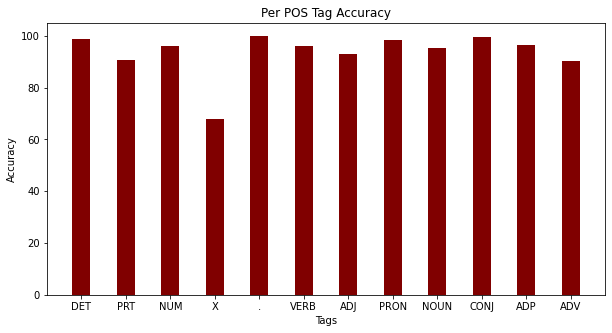

average accuracy for tag  DET  =  98.57515675121758
average accuracy for tag  PRT  =  90.62934313989075
average accuracy for tag  NUM  =  95.82935672480906
average accuracy for tag  X  =  67.7303768066006
average accuracy for tag  .  =  99.8999967409997
average accuracy for tag  VERB  =  96.1634143711201
average accuracy for tag  ADJ  =  92.91652564457715
average accuracy for tag  PRON  =  98.50436922296518
average accuracy for tag  NOUN  =  95.09407703056401
average accuracy for tag  CONJ  =  99.43388942376157
average accuracy for tag  ADP  =  96.46992411168173
average accuracy for tag  ADV  =  90.24877515265663
Overall Accuracy for POS tagging =  0.9625784422342871


In [212]:
x=[]
y=[]
for i in averagePerPOSAcc:
    x.append(i)
    y.append(averagePerPOSAcc[i]*100)


fig = plt.figure(figsize = (10, 5)) 

# creating the bar plot 
plt.bar(x, y, color ='maroon',  
        width = 0.4) 
  
plt.xlabel("Tags") 
plt.ylabel("Accuracy") 
plt.title("Per POS Tag Accuracy") 
plt.show() 

for i in range(len(x)):
    print("average accuracy for tag ",x[i]," = ",y[i])
print("Overall Accuracy for POS tagging = ", average_acc)

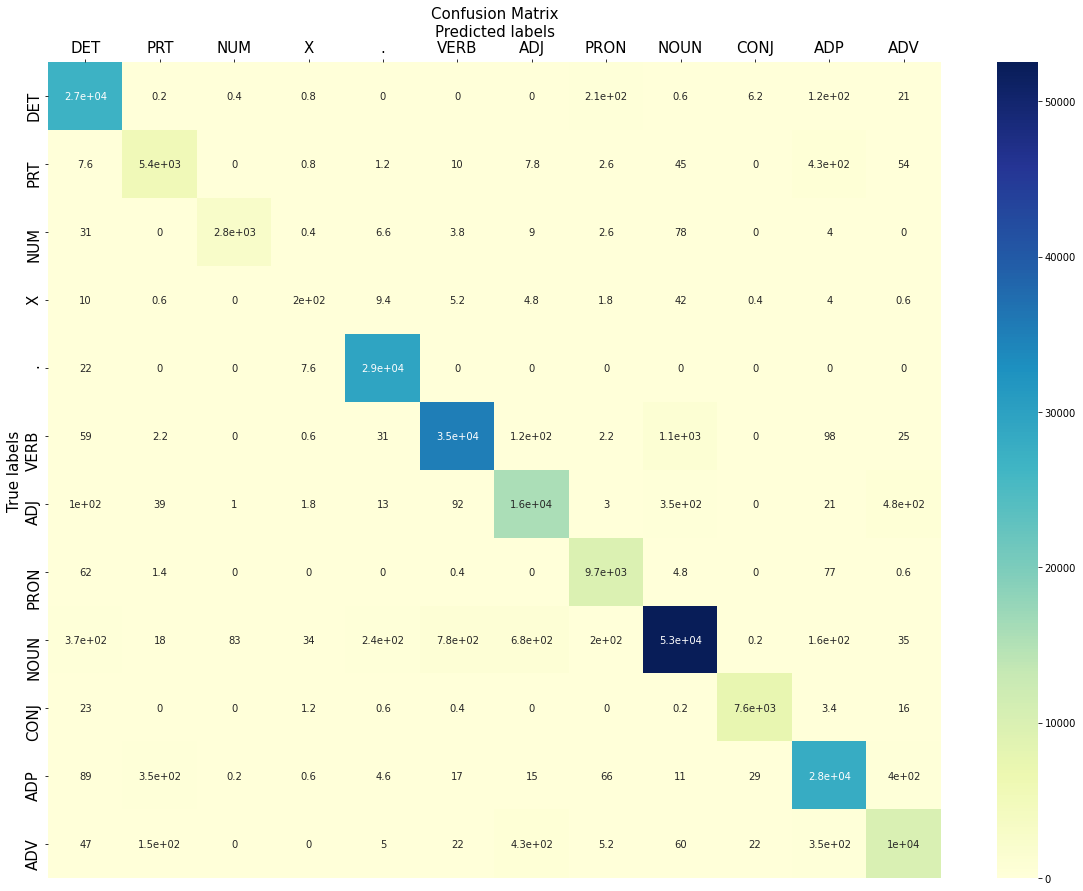

In [213]:
f = plt.figure(figsize=(20,15))
ax= f.add_subplot()
sns.heatmap(sum(TempCM)/len(TempCM), annot=True, ax = ax,cmap="YlGnBu"); #annot=True to annotate cells
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
# labels, title and ticks
ax.set_xlabel('Predicted labels',fontsize=15);ax.set_ylabel('True labels',fontsize=15); 
ax.set_title('Confusion Matrix',fontsize=15); 
ax.xaxis.set_ticklabels(TempTagSequence[0],fontsize=15); ax.yaxis.set_ticklabels(TempTagSequence[0],fontsize=15);